In [1]:
from rasterstats import zonal_stats, point_query
import rasterio
import fiona
from shapely.geometry import Point

## Reading zipped ASCII file

https://rasterio.readthedocs.io/en/stable/topics/datasets.html

In [2]:
pm25 = rasterio.open('zip://GWRwSPEC_PM25_NA_200001_200012-RH35-NoNegs.asc.zip!/GWRwSPEC_PM25_NA_200001_200012-RH35-NoNegs.asc')
pm25.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -999.9000244140625,
 'width': 9300,
 'height': 4550,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.01, 0.0, -138.0,
        0.0, -0.01, 68.0)}

.transform now returns an Affine()

In [3]:
pm25.crs

CRS.from_epsg(4326)

In [4]:
pm25.transform

Affine(0.01, 0.0, -138.0,
       0.0, -0.01, 68.0)

In [5]:
pm25.read(1)

array([[   1.6,    1.6,    1.6, ...,    1.2,    1.2,    1.2],
       [   1.6,    1.6,    1.6, ...,    1.2,    1.2,    1.2],
       [   1.6,    1.6,    1.6, ...,    1.2,    1.2,    1.2],
       ...,
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9]],
      dtype=float32)

In [6]:
c = fiona.open('zip://popctr_blkgrp2010.zip')

In [7]:
len(c)

220334

In [8]:
c.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('FIPS', 'str:12'),
               ('STATE', 'str:2'),
               ('COUNTY', 'str:3'),
               ('TRACT', 'str:6'),
               ('BLKGRP', 'str:1'),
               ('POPULATION', 'int:5'),
               ('LATITUDE', 'float:9.6'),
               ('LONGITUDE', 'float:11.6')]),
  'geometry': 'Point'},
 'crs': {'init': 'epsg:4269'},
 'crs_wkt': 'GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]'}

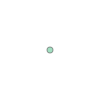

In [9]:
rec = next(iter(c))
pt = Point(rec['geometry']['coordinates'])
pt

In [10]:
rec

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('FIPS', '010010201001'),
              ('STATE', '01'),
              ('COUNTY', '001'),
              ('TRACT', '020100'),
              ('BLKGRP', '1'),
              ('POPULATION', 698),
              ('LATITUDE', 32.464812),
              ('LONGITUDE', -86.486527)]),
 'geometry': {'type': 'Point', 'coordinates': (-86.486527, 32.464812)}}

## Point queries

Would like some verification that the point_query is paying attention to the differing CRS of each of these...

In [11]:
point_query([pt], pm25.read(1), affine=pm25.transform, nodata=-999)

[16.299999237060547]

In [12]:
pts_list = []
for cc in iter(c):
    pts_list.append(Point(cc['geometry']['coordinates']))
    if len(pts_list)==10:
        break

In [13]:
pts = point_query(pts_list, pm25.read(1), affine=pm25.transform, nodata=-999)
pts

[16.299999237060547,
 16.299999237060547,
 16.19851024725351,
 16.246879944502222,
 16.1097363466093,
 16.12439381652304,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727]

## Just do the query on shapefile directly

### 42 sec laptop, 72 sec desktop, ?? sec DVS lab

In [14]:
pts = point_query(c, pm25.read(1), affine=pm25.transform, nodata=-999)

In [15]:
len(pts)

220334

In [16]:
pts[:10]

[16.299999237060547,
 16.299999237060547,
 16.19851024725351,
 16.246879944502222,
 16.1097363466093,
 16.12439381652304,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727]

### That seems to be the same as when grab points...

---

### Just grab all the points out of the shapefile

In [17]:
full_pts = [Point(cc['geometry']['coordinates']) for cc in iter(c)]
full_pts[:10]

In [18]:
len(full_pts)

220334

### 2 sec

In [19]:
pts = point_query(full_pts[:10000], pm25.read(1), affine=pm25.transform, nodata=-999)
pts[-10:]

[11.761720062264374,
 11.789500150680539,
 11.707340627268032,
 13.076494545913299,
 13.36290983076092,
 12.660678060852362,
 12.12775029658391,
 13.304109938908024,
 12.602310200882357,
 11.881680069160332]

### 18 sec

In [20]:
pts = point_query(full_pts[:100000], pm25.read(1), affine=pm25.transform, nodata=-999)
pts[-10:]

[10.548170183753996,
 10.56679020896553,
 10.626140231895388,
 10.532180122756928,
 10.700297770401756,
 10.699999809265137,
 10.665676559665428,
 10.671079974746688,
 10.787997923950002,
 10.706289833259572]

### 42 sec

In [21]:
pts = point_query(full_pts, pm25.read(1), affine=pm25.transform, nodata=-999)
pts[-10:]

[None, None, None, None, None, None, None, None, None, None]

In [22]:
c.close()
pm25.close()